In [1]:
!pip install qiskit --quiet
!pip install qiskit_machine_learning --quiet

     |████████████████████████████████| 6.1 MB 3.4 MB/s 
     |████████████████████████████████| 17.9 MB 112 kB/s 
     |████████████████████████████████| 236 kB 61.0 MB/s 
     |████████████████████████████████| 207 kB 51.6 MB/s 
     |████████████████████████████████| 2.1 MB 48.6 MB/s 
     |████████████████████████████████| 1.4 MB 37.8 MB/s 
     |████████████████████████████████| 634 kB 23.4 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 38.2 MB 19 kB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 943 kB 41.1 MB/s 
     |████████████████████████████████| 3.5 MB 35.5 MB/s 
     |████████████████████████████████| 6.3 MB 34.4 MB/s 
     |████████████████████████████████| 96 kB 2.7 MB/s 


In [2]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm 

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer, BasicAer, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info.operators import Operator
from qiskit.ml.datasets import wine
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.circuits import StateVectorCircuit
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import Optimizer, COBYLA, ADAM, AQGD 
from qiskit.aqua.utils.arithmetic import normalize_vector
from qiskit.aqua.utils.circuit_utils import convert_to_basis_gates
from qiskit.quantum_info import state_fidelity
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import Parameter, ParameterVector, Instruction
from qiskit.circuit.library import RealAmplitudes,ZFeatureMap, ZZFeatureMap, EfficientSU2, PauliFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance

# importing Qiskit Machine learning
import qiskit_machine_learning
from qiskit_machine_learning.neural_networks import OpflowQNN, CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.circuit.library import RawFeatureVector

#import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

import tensorflow as tf

import torch
from torch import Tensor, cat, no_grad, mul
from torch.nn import Linear, CrossEntropyLoss, MSELoss, HingeEmbeddingLoss, MultiMarginLoss
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F

import cv2

/usr/local/lib/python3.7/dist-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/usr/local/lib/python3.7/dist-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')


In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=10)

In [4]:
def PrepareState(states):
    return normalize_vector(states)
def filter_(x, y, c=(8,1)):
    keep = (y == c[0]) | (y == c[1])
    x, y = x[keep], y[keep]
    y = y == c[0]
    return 1*x,1*y
def filter_81_200(x, y):
    keep8 = (y == 8) 
    keep1 = (y == 1)
    x8, y8 = x[keep8][:100], y[keep8][:100]
    x1, y1 = x[keep1][:100], y[keep1][:100]
    y8 = y8 == 1
    y1 = y1 == 1
    
    x = np.concatenate((x8,x1))
    y = np.concatenate((y8,y1))
    return 1*x,1*y
def convert_to_circuit(features):
    states = PrepareState(features)
    qc = QuantumCircuit(qr)
    qc.initialize(states,[qr[i] for i in range(1,5)])
    qc_basis = convert_to_basis_gates(qc)
    return qc_basis

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
""
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_train))

11501568/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 60000


In [6]:
c = (3,6)
x_train, y_train = filter_(x_train, y_train, c)
x_test, y_test = filter_(x_test, y_test, c)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


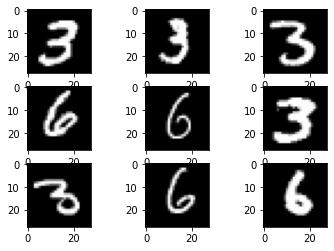

In [7]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i].reshape(28,28),cmap='gray')
plt.show()

In [8]:
imsize = 16
X_train = np.array([ cv2.resize(x, (np.sqrt(imsize).astype(np.int64)\
                                    ,np.sqrt(imsize).astype(np.int64)))\
                    .reshape(imsize,) for x in x_train])
X_test = np.array([ cv2.resize(x, (np.sqrt(imsize).astype(np.int64)\
                                   ,np.sqrt(imsize).astype(np.int64)))\
                   .reshape(imsize,) for x in x_test])

print(X_train[0].shape)
print(X_test[0].shape)

(16,)
(16,)


In [9]:
import collections
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_8 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_1 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 8s: ", num_uniq_8)
    print("Number of unique 1s: ", num_uniq_1)
    print("Number of unique contradicting labels (both 8 and 1): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [10]:
x_train_nocon, y_train_nocon = remove_contradicting(X_train, y_train)

Number of unique images: 10387
Number of unique 8s:  4912
Number of unique 1s:  5426
Number of unique contradicting labels (both 8 and 1):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [11]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(X_test > THRESHOLD, dtype=np.float32)

In [12]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 8s:  80
Number of unique 1s:  69
Number of unique contradicting labels (both 8 and 1):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


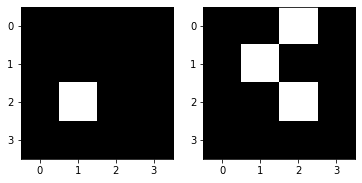

In [13]:
plt.subplot(121)
plt.imshow(x_train_bin[y_train_nocon==0][7].reshape(np.sqrt(imsize).astype(np.int64)\
                                  ,np.sqrt(imsize).astype(np.int64)\
                                  ),cmap='gray')
plt.subplot(122)
plt.imshow(x_train_bin[y_train_nocon==0][0].reshape(np.sqrt(imsize).astype(np.int64)\
                                  ,np.sqrt(imsize).astype(np.int64)\
                                  ),cmap='gray')
plt.show()

In [14]:
X_train.shape

(12049, 16)

In [15]:
x_train_bin

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
x_train_nocon.shape

(10338, 16)

In [18]:
X_train = torch.from_numpy(x_train_bin)
X_test = torch.from_numpy(x_test_bin)
y_train = torch.from_numpy(np.array(y_train_nocon))
y_test = torch.from_numpy(np.array(y_test))

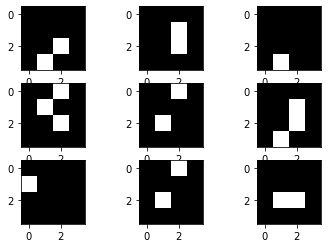

In [19]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i].reshape(np.sqrt(imsize).astype(np.int64)\
                                  ,np.sqrt(imsize).astype(np.int64)\
                                  ),cmap='gray')
plt.show()

In [20]:
print('label 3 shape: {}\nlabel 6 shape: {} '.format(X_train.shape,X_train.shape))

label 3 shape: torch.Size([10338, 16])
label 6 shape: torch.Size([10338, 16]) 


In [21]:
parity = lambda x: '{:b}'.format(x).count('1') % 2
output_shape = 2  # parity = 0, 1

In [24]:
inputs = [Parameter(f'p{x+1}') for x in range(16)]
weights = [Parameter(f'x{x+1}') for x in range(32)]

In [25]:
def ansatz_init(weights):
    ansatz = QuantumCircuit(17)
    ansatz.x(0)
    ansatz.h(0)
      # Rxx
    for i in range(32//2):
        ansatz.rxx(weights[i],i+1,0) 
      # Rzz
    j = 1
    for i in range(32//2,32,1):
        ansatz.rzz(weights[i],j,0) 
        j = j+1
    ansatz.h(0)
    return ansatz

In [26]:
X_train

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [27]:
qc = QuantumCircuit(17)
for i in range(16):
  qc.ry(np.pi*inputs[i], i+1)
qc+=ansatz_init(weights)

qc_sfn = StateFn(qc)
# construct cost operator
H = StateFn(PauliSumOp.from_list([('ZIIIIIIIIIIIIIIII', 1.0)]))

# combine operator and circuit to objective function
op = ~H @ qc_sfn

qnn = OpflowQNN(operator = op, input_params = inputs, weight_params = weights, exp_val = expval, gradient = gradient, quantum_instance = qi_qasm, input_gradients=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


In [28]:
from qiskit.utils import algorithm_globals

In [29]:
algorithm_globals.massive=True 

In [30]:
torch.get_num_threads()

1

In [38]:
batch_size = 32
dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
total = len(train_loader)

In [31]:
np.random.seed(10)
initial_weights = 0.1*(2*np.random.rand(qnn.num_weights) - 1)
model1 = TorchConnector(qnn, initial_weights=initial_weights)

In [35]:
class HingeLoss(torch.nn.Module):

    def __init__(self):
        super(HingeLoss, self).__init__()
        self.relu = torch.nn.ReLU()

    def forward(self, output, target):
        all_ones = torch.ones_like(target)
        labels = 2 * target - all_ones
        losses = all_ones - torch.mul(output, labels)

        return torch.norm(self.relu(losses))

In [39]:
def train_model(model):
    # define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters())
    loss_func = HingeLoss()

    # start training
    epochs = 4     # set number of epochs
    loss_list = []  # store loss history
    model.train()  # set model to training mode
    for epoch in range(epochs):
        total_loss = []
        with tqdm(total=total) as pbar:
            for batch_idx, (data, target) in enumerate(train_loader):
              pbar.update(1)
              optimizer.zero_grad(set_to_none=True)  # initialize gradient
              
              output = model(data)        # forward pass
              loss = loss_func(output, target)       # calculate loss
              loss.backward()                        # backward pass
              optimizer.step()                       # optimize weights
              total_loss.append(loss.item())         # store loss

        loss_list.append(sum(total_loss)/len(total_loss))
        print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
              100. * (epoch + 1) / epochs, loss_list[-1]))
    return model, loss_list

In [ ]:
%%time
model, loss = train_model(model1)

  1%|          | 4/324 [05:12<7:19:23, 82.39s/it]